# Understand participant characteristic

Data type of missing_pct_cells in missingness_df:  float64
Any NaN values in missing_pct_cells column after conversion:  0
First few rows of participant_df with missing_pct_cells assigned:
         pid  missing_pct_cells
0  INS-W_300              44.15
1  INS-W_302              42.01
2  INS-W_303              23.24
3  INS-W_304              19.74
4  INS-W_305              20.87
Participant dataframe has shape: 
(513, 66)


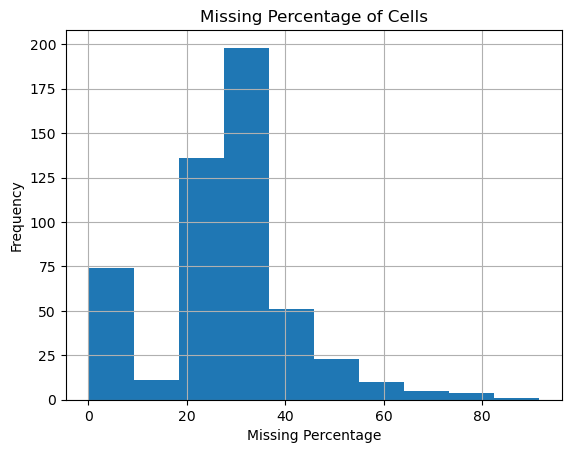

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
participant_df = pd.read_csv("combined_participants_info.csv")
missingness_df = pd.read_csv("missing_by_pid_after_feature_filter.csv")

# Check data types
print("Data type of missing_pct_cells in missingness_df: ", missingness_df["missing_pct_cells"].dtype)

# Convert 'missing_pct_cells' to numeric, forcing errors to NaN (if any invalid entries exist)
missingness_df["missing_pct_cells"] = pd.to_numeric(missingness_df["missing_pct_cells"], errors='coerce')

# Check for any NaN values in the 'missing_pct_cells' column after conversion
print("Any NaN values in missing_pct_cells column after conversion: ", missingness_df["missing_pct_cells"].isna().sum())

# Ensure participant_df and missingness_df align properly
participant_df["missing_pct_cells"] = missingness_df["missing_pct_cells"]

# Check if the assignment worked correctly
print("First few rows of participant_df with missing_pct_cells assigned:")
print(participant_df[["pid", "missing_pct_cells"]].head())

# Check the shape again
print("Participant dataframe has shape: ")
print(participant_df.shape)

# Optionally: plot the missing_pct_cells to visually inspect the values
participant_df["missing_pct_cells"].hist()
plt.title('Missing Percentage of Cells')
plt.xlabel('Missing Percentage')
plt.ylabel('Frequency')
plt.show()

In [95]:
participant_df["missing_pct_cells"]

0      44.15
1      42.01
2      23.24
3      19.74
4      20.87
       ...  
819     8.78
820     7.43
821     6.82
822     7.43
823     6.30
Name: missing_pct_cells, Length: 824, dtype: float64

In [105]:
df = pd.read_csv("data/globem_raw/INS-W_2/SurveyData/pre.csv")
df["BDI2_PRE"].notna().sum()

245

In [112]:
filtered_pdf = participant_df.loc[(participant_df["BDI2_PRE"]).notna() & \
                                (participant_df["BDI2_POST"]).notna() & \
                                (participant_df["n_days"] >= 80),
                                :]


In [113]:
participant_df["BDI2_POST"].notna().sum()

513

In [114]:
filtered_pdf.to_csv("participants_w_bdi2_pre_post.csv", index=False)

In [115]:
# Apply the condition to count participants with normal BDI2 pre and abnormal BDI2 post
condition = (filtered_pdf["BDI2_PRE"] <= 13) & (filtered_pdf["BDI2_POST"] >= 20)

# Count the participants that meet the condition
count = filtered_pdf[condition].shape[0]

print(f"Number of participants with normal BDI2 pre and abnormal BDI2 post: {count}")
print(f"Example participants: {filtered_pdf.loc[condition, 'pid'].tolist()}")

Number of participants with normal BDI2 pre and abnormal BDI2 post: 22
Example participants: ['INS-W_322', 'INS-W_335', 'INS-W_336', 'INS-W_360', 'INS-W_427', 'INS-W_504', 'INS-W_508', 'INS-W_518', 'INS-W_537', 'INS-W_541', 'INS-W_698', 'INS-W_701', 'INS-W_744', 'INS-W_751', 'INS-W_1000', 'INS-W_1031', 'INS-W_1038', 'INS-W_1080', 'INS-W_1081', 'INS-W_913', 'INS-W_974', 'INS-W_991']


In [ ]:
# Apply the condition to count participants with normal BDI2 pre and abnormal BDI2 post
condition = (filtered_pdf["BDI2_PRE"] <= 13) & (filtered_pdf["BDI2_POST"] <= 13)

# Count the participants that meet the condition
count = filtered_pdf[condition].shape[0]

print(f"Number of participants with normal BDI2 pre and normal BDI2 post: {count}")

Number of participants with normal BDI2 pre and normal BDI2 post: 291


In [52]:
# Apply the condition to count participants with normal BDI2 pre and abnormal BDI2 post
condition = (filtered_pdf["BDI2_PRE"] >= 20) & (filtered_pdf["BDI2_POST"] >= 20)

# Count the participants that meet the condition
count = filtered_pdf[condition].shape[0]

print(f"Number of participants with abnormal BDI2 pre and abnormal BDI2 post: {count}")

Number of participants with abnormal BDI2 pre and abnormal BDI2 post: 78


In [ ]:
import os
import pandas as pd

def get_participant_data(pid, globem_root):
    participant_data_df = pd.DataFrame()
    # Iterate through the years (INS-W_1, INS-W_2, INS-W_3, INS-W_4)
    for year in ["INS-W_1", "INS-W_2", "INS-W_3", "INS-W_4"]:
        participant_folder = os.path.join(globem_root, year, "FeatureData")

        # Check if rapids.csv exists for the participant in the given year folder
        rapids_file = os.path.join(participant_folder, "rapids.csv")
        if os.path.isfile(rapids_file):
            rapids_df = pd.read_csv(rapids_file)

            # Filter for the data corresponding to the specific participant (pid)
            participant_data_for_pid = rapids_df[rapids_df["pid"] == pid]

            # If there is data for the participant, append it to the result dictionary
            if not participant_data_for_pid.empty:
                participant_data_df = participant_data_for_pid

    return participant_data_df


# Usage
globem_root = "/Users/kwang/Data/globem"  # Update to your actual globem root directory
pid = "INS-W_335"  # Replace with the actual participant ID you're interested in

# Get the DataFrame of available features for the participant (day-wise)
participant_feature_data = get_participant_data(pid, globem_root)

# Print the resulting DataFrame shape and the first few rows for inspection
print("Participant data shape: ", participant_feature_data.shape)
participant_feature_data.head()


322 does not have any sleep data

In [72]:
sleep_features = [col for col in participant_feature_data.columns if "sleep" in col.lower() or "slp" in col.lower()]
print(len(sleep_features))
(participant_feature_data[sleep_features].notna().sum() > 0).sum()

918


726

In [84]:
selected_sleep_features = [
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:morning",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:afternoon",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:afternoon",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:evening",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:evening",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:night",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:night",
]

In [86]:
import os
import pandas as pd

def get_participant_data(pid, globem_root, selected_sleep_features):
    participant_data_df = pd.DataFrame()
    
    # Iterate through the years (INS-W_1, INS-W_2, INS-W_3, INS-W_4)
    for year in ["INS-W_1", "INS-W_2", "INS-W_3", "INS-W_4"]:
        participant_folder = os.path.join(globem_root, year, "FeatureData")

        # Check if rapids.csv exists for the participant in the given year folder
        rapids_file = os.path.join(participant_folder, "rapids.csv")
        if os.path.isfile(rapids_file):
            rapids_df = pd.read_csv(rapids_file)

            # Filter for the data corresponding to the specific participant (pid)
            participant_data_for_pid = rapids_df[rapids_df["pid"] == pid]

            # If there is data for the participant, select only the relevant columns (including 'pid' and 'date')
            if not participant_data_for_pid.empty:
                participant_data_for_pid = participant_data_for_pid[["pid", "date"] + [feature for feature in selected_sleep_features if feature in rapids_df.columns]]
                participant_data_df = participant_data_for_pid

    return participant_data_df


# Usage
globem_root = "/Users/kwang/Data/globem"  # Update to your actual globem root directory
pid = "INS-W_335"  # Replace with the actual participant ID you're interested in

# List of selected features
selected_sleep_features = [
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:morning",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:afternoon",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:afternoon",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:evening",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:evening",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:night",
    "f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:night",
]

# Get the DataFrame of available features for the participant (day-wise)
participant_sleep_feature_data = get_participant_data(pid, globem_root, selected_sleep_features)

# Print the resulting DataFrame shape and the first few rows for inspection
print("Participant data shape: ", participant_sleep_feature_data.shape)
participant_sleep_feature_data.head()

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_51153/2707940444.py:14: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,243,244,264,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,855,856,864,876,898,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1467,1468,1472,1473,1474,1475,1476,1477,1478,1479,1480,1484,1485,1486,1487,1488,1489,1490,1491,1492,1510,1534,1535,1536,1537,1538,1539,1540,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,205

Participant data shape:  (97, 10)


,pid,date,f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning,f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:morning,f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:afternoon,f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:afternoon,f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:evening,f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:evening,f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:night,f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:night
2813,INS-W_335,2019-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2814,INS-W_335,2019-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2815,INS-W_335,2019-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2816,INS-W_335,2019-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2817,INS-W_335,2019-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
participant_sleep_feature_data.notna().sum()

pid                                                                          97
date                                                                         97
f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning      64
f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:morning       64
f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:afternoon    21
f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:afternoon     21
f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:evening       3
f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:evening        3
f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:night        65
f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:night         65
dtype: int64

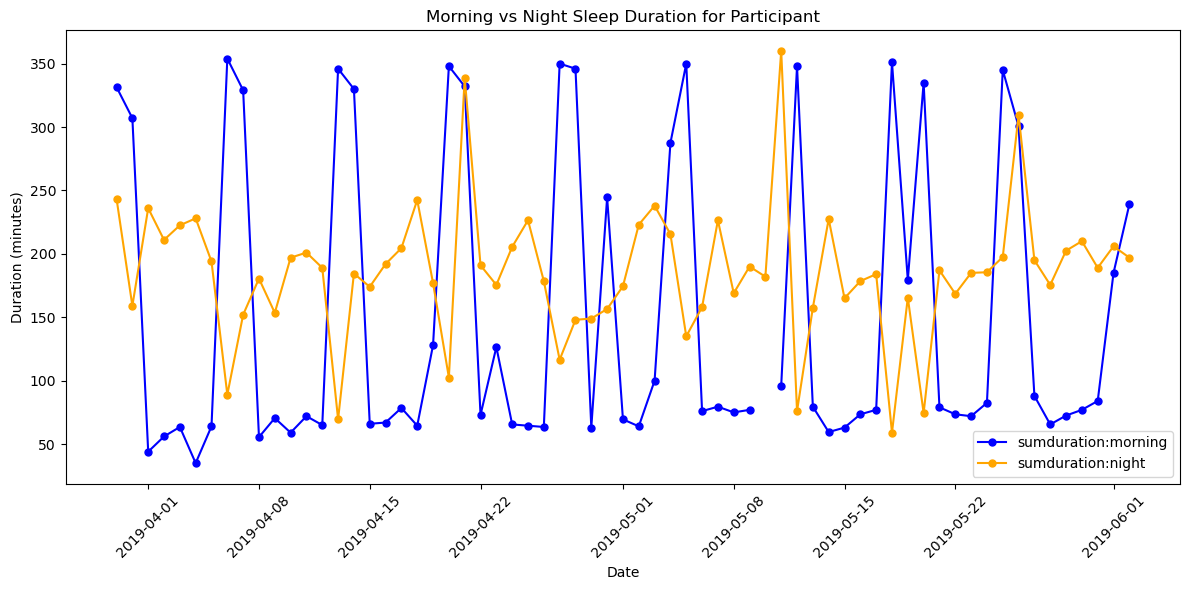

In [88]:
import matplotlib.pyplot as plt

# Ensure that the 'date' column is of datetime type
participant_sleep_feature_data['date'] = pd.to_datetime(participant_sleep_feature_data['date'])

# Sort the data by date
participant_sleep_feature_data_sorted = participant_sleep_feature_data.sort_values(by='date')

# Plotting the data for the night and morning durations
plt.figure(figsize=(12, 6))

# Plot for sumduration:morning and sumduration:night
plt.plot(participant_sleep_feature_data_sorted['date'], 
         participant_sleep_feature_data_sorted['f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:morning'], 
         label='sumduration:morning', color='blue', marker='o', linestyle='-', markersize=5)

plt.plot(participant_sleep_feature_data_sorted['date'], 
         participant_sleep_feature_data_sorted['f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:night'], 
         label='sumduration:night', color='orange', marker='o', linestyle='-', markersize=5)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
plt.title('Morning vs Night Sleep Duration for Participant')
plt.legend()

# Rotate the x-axis labels to make them readable
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [65]:
import pandas as pd

def filter_features(participant_feature_data):
    # Step 1: Filter out columns with more than 50% missingness, except 'date'
    missingness_threshold = 0.5
    participant_feature_data_filtered = participant_feature_data.loc[:, 
        (participant_feature_data.isnull().mean() < missingness_threshold) | (participant_feature_data.columns == 'date')
    ]
    print("after missingness threshold selection")
    print(participant_feature_data_filtered.shape)
    
    # Step 2: Filter out columns that are not of dtype float or int, except 'date'
    participant_feature_data_filtered = participant_feature_data_filtered.select_dtypes(include=["float64", "int64"])
    print("after filtering for data type")
    print(participant_feature_data_filtered.shape)
    
    # Ensure 'date' is included
    if 'date' not in participant_feature_data_filtered.columns:
        participant_feature_data_filtered['date'] = participant_feature_data['date']
    
    # Step 3: Filter features that contain "sleep" or "slp" in the name
    sleep_features = [col for col in participant_feature_data_filtered.columns if "sleep" in col.lower() or "slp" in col.lower()]
    
    # Add 'date' back to the list of columns to include
    sleep_features.append('date')
    
    # Final filtered data containing only sleep-related features and 'date'
    filtered_sleep_data = participant_feature_data_filtered[sleep_features]
    
    return filtered_sleep_data


# Usage
# Assuming participant_feature_data is the DataFrame you already have
filtered_participant_sleep_data = filter_features(participant_feature_data)

# Print the resulting DataFrame with only relevant sleep features
print(filtered_participant_sleep_data.shape)
filtered_participant_sleep_data.head()

after missingness threshold selection
(97, 2358)
after filtering for data type
(97, 1571)
(97, 1)


,date
1746,2019-03-21
1747,2019-03-22
1748,2019-03-23
1749,2019-03-24
1750,2019-03-25


In [35]:
missingness_df = pd.read_csv("missing_by_pid_after_feature_filter.csv")
(missingness_df["missing_pct_cells"] < 90).sum()

821

In [30]:
participant_df["missing_pct_cells"] < 0.9

0       False
1       False
2       False
3       False
4       False
        ...  
3291    False
3292    False
3293    False
3294    False
3295    False
Name: missing_pct_cells, Length: 3296, dtype: bool

In [ ]:
print("# participants with no depression", (participant_df["BDI2"] <= 13).sum())
print("# participants with moderate or severe depression", (participant_df["BDI2"] >= 20).sum())
print("# participants with severe depression", (participant_df["BDI2"] >= 29).sum())

# participants with no depression 395
# participants with moderate or severe depression 156
# participants with severe depression 61


# Older code

Matplotlib is building the font cache; this may take a moment.


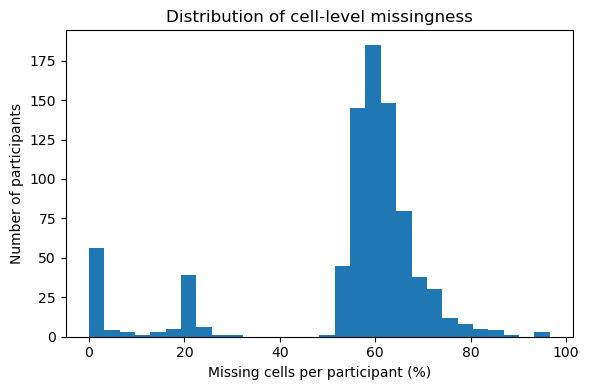

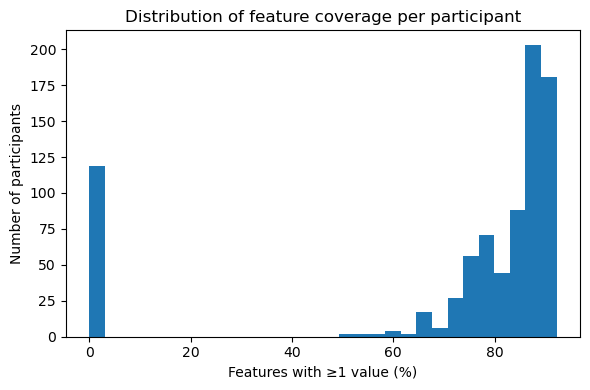

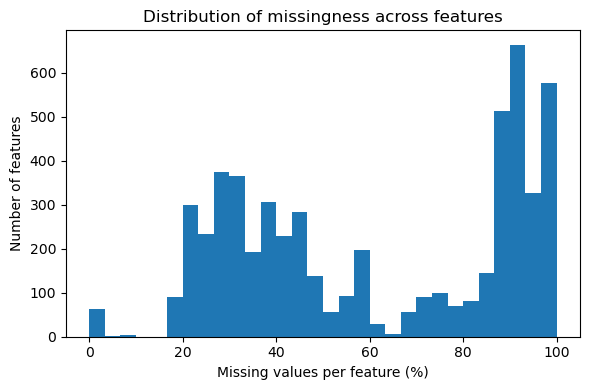

{'Participants (rows)': 824,
 'Features (columns)': 5583,
 'Median missing% per participant': np.float64(59.625),
 'Median missing% per feature': np.float64(57.8144)}

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- load the two summary tables you just created ----------
feature_info = pd.read_csv("feature_info.csv")
pid_info = pd.read_csv("missing_by_pid.csv")

# ---------- 1) Histogram of cell‑level missingness -----------------
plt.figure(figsize=(6, 4))
plt.hist(pid_info["missing_pct_cells"].dropna(), bins=30)
plt.xlabel("Missing cells per participant (%)")
plt.ylabel("Number of participants")
plt.title("Distribution of cell‑level missingness")
plt.tight_layout()
plt.show()

# ---------- 2) Histogram of feature availability ------------------
plt.figure(figsize=(6, 4))
plt.hist(pid_info["feature_pct_available"].dropna(), bins=30)
plt.xlabel("Features with ≥1 value (%)")
plt.ylabel("Number of participants")
plt.title("Distribution of feature coverage per participant")
plt.tight_layout()
plt.show()

# ---------- 3) Histogram of feature‑level missingness -------------
plt.figure(figsize=(6, 4))
plt.hist(feature_info["missing_pct"].dropna(), bins=30)
plt.xlabel("Missing values per feature (%)")
plt.ylabel("Number of features")
plt.title("Distribution of missingness across features")
plt.tight_layout()
plt.show()

# ---------- quick numeric summaries -------------------------------
summary = {
    "Participants (rows)": len(pid_info),
    "Features (columns)": len(feature_info),
    "Median missing% per participant": pid_info["missing_pct_cells"].median(),
    "Median missing% per feature": feature_info["missing_pct"].median(),
}
summary


<Axes: >

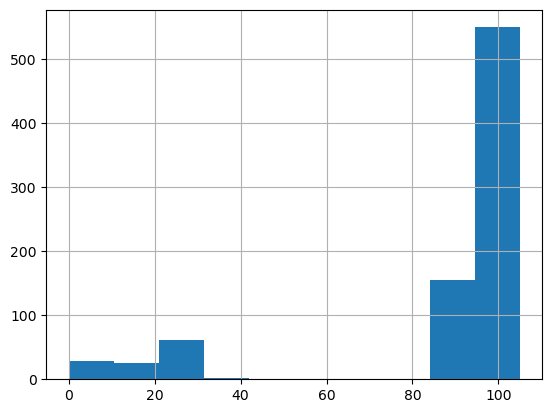

In [3]:
pid_info['n_days'].hist()

In [4]:
import pandas as pd
from pathlib import Path
from IPython.display import display

# ---- adjust this if your notebook isn't in the repo root -------------
DATA_DIR = Path(".")          # "." assumes the CSVs are next to the notebook
# DATA_DIR = Path("..")       # uncomment if CSVs live one level up

# ---------------------------------------------------------------------
feature_info = pd.read_csv(DATA_DIR / "feature_info.csv")
pid_info     = pd.read_csv(DATA_DIR / "missing_by_pid.csv")

# ---------------- apply your thresholds ------------------------------
valid_features = (
    feature_info.loc[feature_info["missing_pct"] < 50, "column"]
    .dropna()
    .loc[lambda s: s != "pid"]            # exclude identifier
    .sort_values()
)

accepted_pids = (
    pid_info[
        (pid_info["n_days"] > 80) &
        (pid_info["missing_pct_cells"] < 50) &
        (pid_info["feature_pct_available"] > 50)
    ]["pid"]
    .dropna()
    .sort_values()
)

# ---------------- save to simple lists --------------------------------
valid_features.to_csv(DATA_DIR / "valid_features.csv", index=False, header=False)
accepted_pids.to_csv(DATA_DIR / "accepted_pids.csv", index=False, header=False)

print(f"Kept {len(valid_features)} features (saved to valid_features.csv)")
print(f"Kept {len(accepted_pids)} participants (saved to accepted_pids.csv)")

# ---------------- quick preview ---------------------------------------
print("\nFirst 10 valid features:")
display(valid_features.head(10).to_frame().T)

print("\nFirst 10 accepted pids:")
display(accepted_pids.head(10).to_frame().T)


Kept 2578 features (saved to valid_features.csv)
Kept 1 participants (saved to accepted_pids.csv)

First 10 valid features:


,0,1,2,3,4,5,6,7,9,10
column,2waySSS_giving_emotional_POST,2waySSS_giving_emotional_PRE,2waySSS_giving_instrumental_POST,2waySSS_giving_instrumental_PRE,2waySSS_receiving_emotional_POST,2waySSS_receiving_emotional_PRE,2waySSS_receiving_instrumental_POST,2waySSS_receiving_instrumental_PRE,BDI2_POST,BDI2_PRE



First 10 accepted pids:


,125
pid,INS-W_162


Keeping 2578 features with <50% missingness


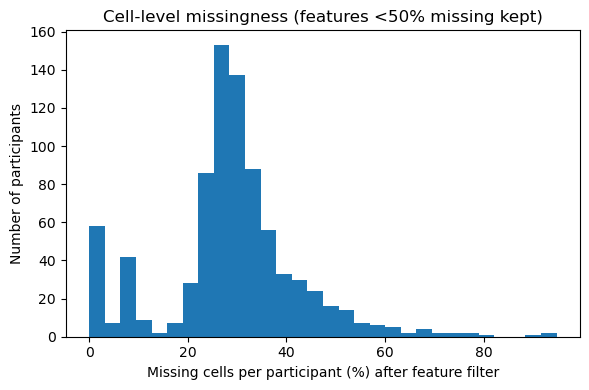

,missing_pct_cells
count,824.000000
mean,28.992439
std,14.217461
min,0.000000
25%,24.385000
50%,28.910000
75%,34.820000
max,94.830000


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd

# --------------- CONFIG -------------------------------------------------
# Location of the summary files (adj. if the notebook is elsewhere)
SUMMARY_DIR = Path(".")           # where feature_info.csv lives
# Root of the raw GLOBEM dataset  (adj. if needed)
GLOBEM_ROOT = Path("data/globem_raw")   # or Path("../data/globem_raw")

# -----------------------------------------------------------------------
# 1) Load feature summary and pick features with <50% missingness
feature_info = pd.read_csv(SUMMARY_DIR / "feature_info.csv")
keep_features = set(
    feature_info.loc[feature_info["missing_pct"] < 50, "column"]
    .dropna()
    .tolist()
)
keep_features.discard("pid")

print(f"Keeping {len(keep_features)} features with <50% missingness")

# -----------------------------------------------------------------------
# 2) Stream through all CSVs again, recompute cell-level missingness per pid
csv_files = sorted(GLOBEM_ROOT.rglob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSVs found under {GLOBEM_ROOT}")

pid_seen = Counter()
pid_total = Counter()

for csv_path in csv_files:
    for chunk in pd.read_csv(csv_path, chunksize=50_000, dtype=str,
                             keep_default_na=True, na_values=["", "na", "NA"]):
        # drop leading blank/Unnamed col
        first = chunk.columns[0]
        if first.strip() == "" or first.startswith("Unnamed"):
            chunk.drop(columns=[first], inplace=True)

        # subset features
        cols_to_use = ["pid"] + [c for c in chunk.columns if c in keep_features]
        chunk = chunk[cols_to_use]

        # update counts
        mask = chunk.iloc[:, 1:].isna()   # exclude pid
        for pid, grp in mask.groupby(chunk["pid"]):
            pid_total[pid] += grp.size
            pid_seen[pid]  += grp.size - grp.values.sum()

# -----------------------------------------------------------------------
# 3) Build new DataFrame
pid_df = pd.DataFrame({
    "pid": list(pid_total.keys()),
    "missing_pct_cells": [
        round(100*(pid_total[p] - pid_seen[p]) / pid_total[p], 2)
        for p in pid_total
    ]
})

# save
pid_df.to_csv(SUMMARY_DIR / "missing_by_pid_after_feature_filter.csv", index=False)

# -----------------------------------------------------------------------
# 4) Plot histogram
plt.figure(figsize=(6,4))
plt.hist(pid_df["missing_pct_cells"], bins=30)
plt.xlabel("Missing cells per participant (%) after feature filter")
plt.ylabel("Number of participants")
plt.title("Cell-level missingness (features <50% missing kept)")
plt.tight_layout()
plt.show()

# Show quick summary stats
display(pid_df.describe())


In [10]:
import pandas as pd
from pathlib import Path

# --------- adjust these paths if needed ----------------------------------
SUMMARY_DIR = Path(".")           # location of summary CSVs
GLOBEM_ROOT = Path("data/globem_raw")   # not used here but kept for ref

# -------------------------------------------------------------------------
# 1) Load the new cell-missingness file (after feature filter)
pid_missing_new = pd.read_csv(SUMMARY_DIR / "missing_by_pid_after_feature_filter.csv")
pid_missing_new = pid_missing_new.rename(columns={"missing_pct_cells": "missing_pct_cells_filtered"})

# 2) Load the original pid summary (for n_days & feature_pct_available)
pid_orig = pd.read_csv(SUMMARY_DIR / "missing_by_pid.csv")[["pid", "n_days", "feature_pct_available"]]

# 1) Merge the two summaries as before
pid_combined = (
    pid_orig[["pid", "n_days", "feature_pct_available"]]
    .merge(pid_missing_new, on="pid", how="inner")
)

# 2) Ensure numeric dtype (invalid parsing → NaN, which will fail the filter)
for col in ["n_days", "feature_pct_available", "missing_pct_cells_filtered"]:
    pid_combined[col] = pd.to_numeric(pid_combined[col], errors="coerce")

# 3) Apply the thresholds
accepted_pids = (
    pid_combined[
        (pid_combined["n_days"] > 80) &
        (pid_combined["feature_pct_available"] > 50) &
        (pid_combined["missing_pct_cells_filtered"] < 40)
    ]["pid"]
    .dropna()
    .sort_values()
)

accepted_pids.to_csv(SUMMARY_DIR / "accepted_pids_filtered.csv",
                     index=False, header=False)

print(f"{len(accepted_pids)} participants saved to accepted_pids_filtered.csv")

576 participants saved to accepted_pids_filtered.csv


In [ ]:
pid_combined.loc[pid_combined["n_days"]>80, :]

,pid,n_days,feature_pct_available,missing_pct_cells_filtered
0,INS-W_001,93,91.17,44.15
1,INS-W_002,93,86.60,42.01
2,INS-W_003,93,89.07,23.24
3,INS-W_004,93,88.86,19.74
4,INS-W_005,93,89.39,20.87
...,...,...,...,...
802,INS-W_994,104,85.97,21.80
803,INS-W_995,104,83.34,26.62
804,INS-W_996,103,82.62,33.68
805,INS-W_998,103,89.23,36.00


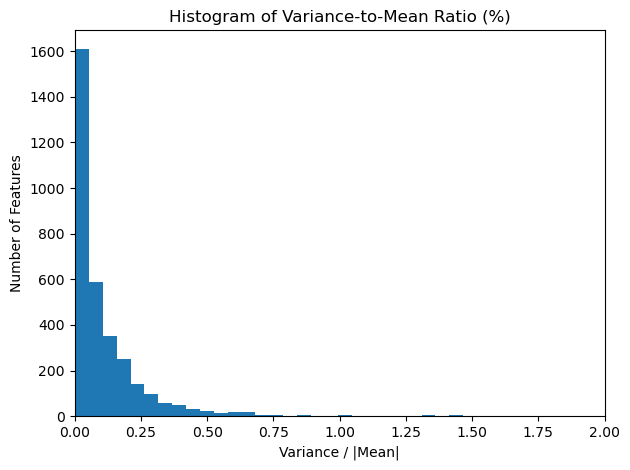

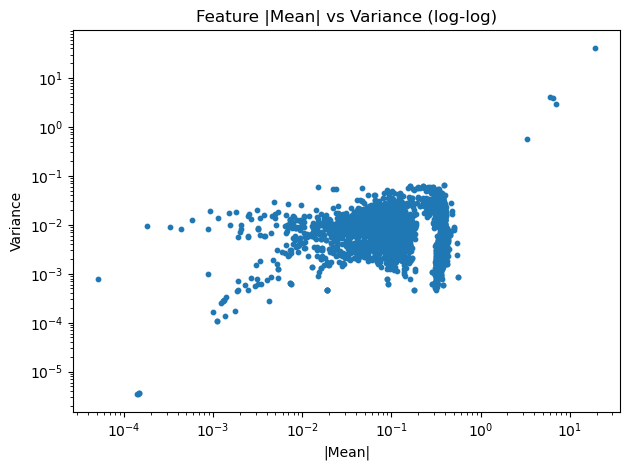

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read the feature statistics file
stats_path = "data/processed/globem_feature_stats.csv"
if not os.path.exists(stats_path):
    raise FileNotFoundError(f"{stats_path} not found. Please upload the stats CSV.")

df = pd.read_csv(stats_path)

# Replace zero means with NaN to avoid divide‑by‑zero errors
df["mean_no_zero"] = df["mean"].replace(0, np.nan).abs()

# Calculate variance‑to‑mean ratio (as a percentage)
df["var_pct_mean"] = (df["var"] / df["mean_no_zero"])

# Drop rows where ratio could not be computed
df_ratio = df.dropna(subset=["var_pct_mean"]).copy()

# ---------------- Histogram of variance‑to‑mean ratio ----------------
plt.figure()
plt.hist(df_ratio["var_pct_mean"], bins=1000)
plt.title("Histogram of Variance‑to‑Mean Ratio (%)")
plt.xlabel("Variance / |Mean|")
plt.ylabel("Number of Features")
plt.xlim([0, 2])
plt.tight_layout()
plt.show()

# ---------------- Scatter plot: |Mean| vs Variance -------------------
plt.figure()
plt.scatter(df_ratio["mean_no_zero"], df_ratio["var"], s=10)
plt.xscale("log")
plt.yscale("log")
plt.title("Feature |Mean| vs Variance (log‑log)")
plt.xlabel("|Mean|")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

In [93]:
info_df = pd.read_csv("/Users/kwang/Codes/mh_causal_llm/causal/combined_participants_info.csv")
info_df.loc[info_df["pid"] == "INS-W_913", "BDI2_PRE"]

726      NaN
1550     NaN
2374     NaN
3198    12.0
Name: BDI2_PRE, dtype: float64